# Analysis of results taken from the experimental framework


Analysis needs to answer three specific questions that standard ML metrics don't cover: TODO: WHY?

- Reliability: Can the model write valid code? (Syntax).

- Accuracy: Does the code actually catch the rule violations? (Logic).

- Stability: Does it solve the problem the same way every time? (Determinism).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [10]:
# Configuration for prettier plots
plt.rcParams['figure.dpi'] = 120

# Directory for autosaving images
IMAGE_DIR = "Thesis/Images"

## Data Wrangling

In [3]:
df = pd.read_csv("Master_Results.csv")

Feature engineering

In [4]:
# Make a runs df ignoring scenarios
# Select ONLY the columns related to the Pipeline (Not the Scenarios)
pipeline_columns = ["Run ID", "Document Name", "Prompts", "Model Name", 
    "Service Graph Hash", "SHACL Graph Hash", "SHACL Valid Syntax", 
    "SHACL Error Type", "SHACL Error Message", "Successfully Executed" ]

# Drop Duplicates (scenarios)
runs_df = df[pipeline_columns].drop_duplicates(subset=["Run ID"])

# Calculate Total Runs for Context
total_n_runs = len(runs_df) 

# Group by Configuration Tuple 
runs_grouped = runs_df.groupby(["Document Name", "Model Name", "Prompts"])

# Tally experiments ran per configuration
runs_grouped.size()

Document Name    Model Name        Prompts  
parental_leave   gemini-2.5-flash  Default      20
                                   Reflexion    20
                                   ZeroShot     20
                 gemini-2.5-pro    Default      10
                                   ZeroShot     10
student_housing  gemini-2.5-flash  Default      20
                                   Reflexion    20
                                   ZeroShot     20
                 gemini-2.5-pro    Default      10
                                   Reflexion    10
                                   ZeroShot     10
dtype: int64

## Syntax Validity

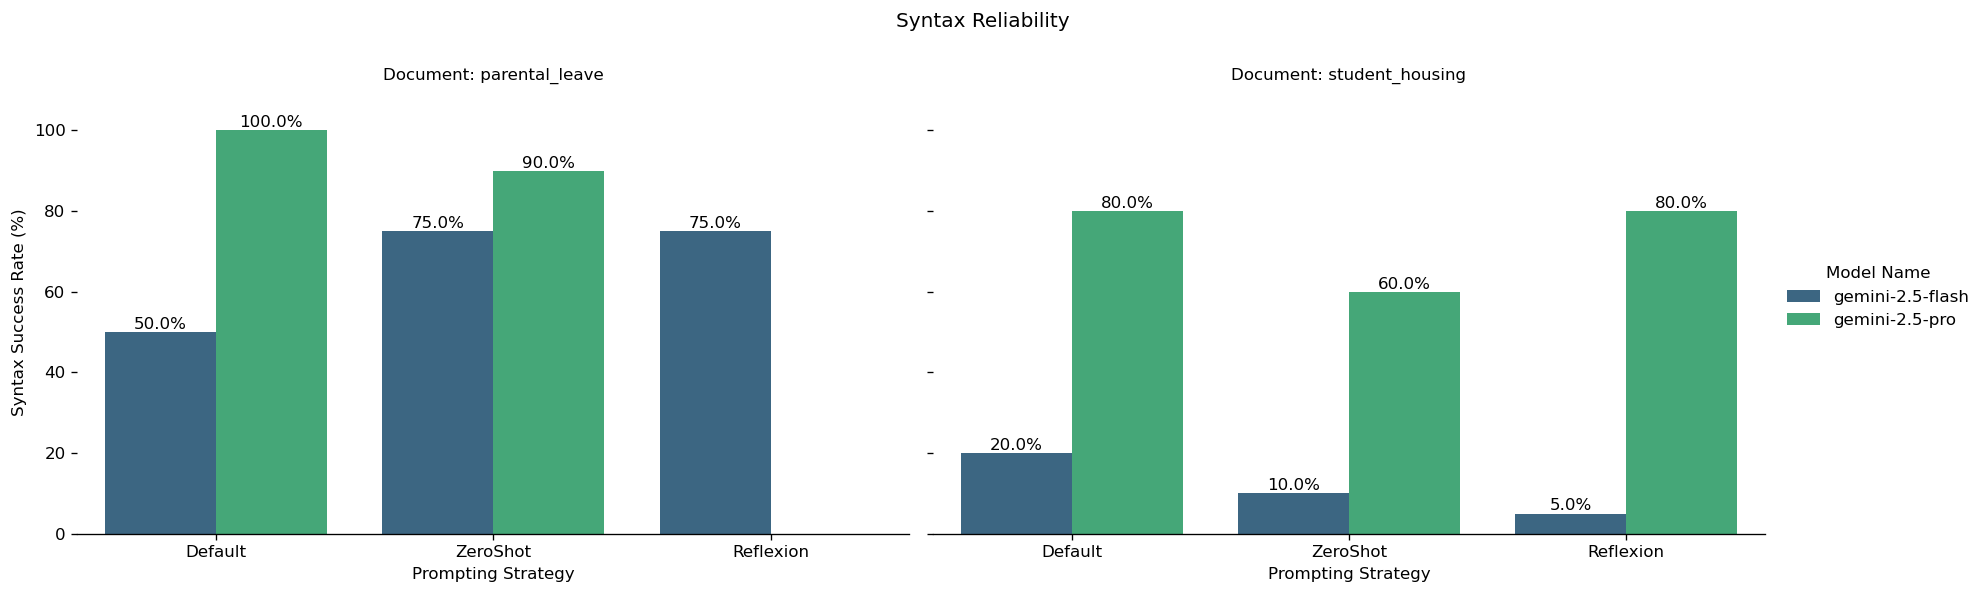

In [29]:
# Calculate Percentage of syntactically successful runs
valid_syntax_runs = runs_grouped["SHACL Valid Syntax"].sum()    # Count syntactically Valid Runs per group
total_runs = runs_grouped.size()    # Count Total Runs per group
syntax_success_rate = (valid_syntax_runs / total_runs) * 100

# Combine into a nice frame
syntax_stats = pd.DataFrame({
    "Total Runs": total_runs,
    "Valid Syntax Runs": valid_syntax_runs,
    "Syntax Success Rate (%)": syntax_success_rate
}).reset_index()

# Draw Chart
g = sns.catplot(
    data=syntax_stats,
    kind="bar",
    x="Prompts",
    y="Syntax Success Rate (%)",
    hue="Model Name",
    col="Document Name",
    palette="viridis",
    height=5, 
    aspect=1.5,
    order=[p for p in ["Default", "ZeroShot", "Reflexion"]] # Define Order for X-Axis
)

# Polish
g.despine(left=True)
g.set_axis_labels("Prompting Strategy", "Syntax Success Rate (%)")
g.set_titles("Document: {col_name}")
plt.ylim(0, 110)

# Add Labels
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')

plt.subplots_adjust(top=0.85)
g.figure.suptitle("Syntax Reliability")
plt.savefig(f"{IMAGE_DIR}/Syntax Reliability.png", dpi=300, bbox_inches='tight')
plt.show()

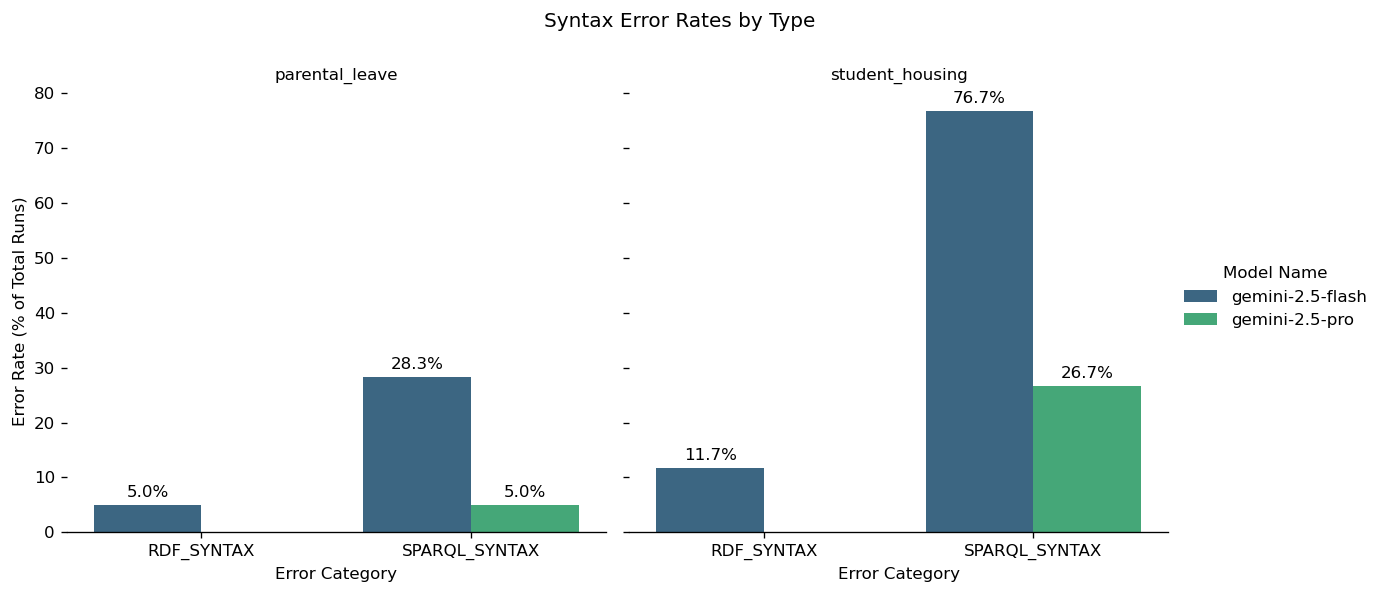

In [37]:
# Calculate Totals 
runs_totals = runs_df.groupby(["Document Name", "Model Name"]).size().reset_index(name='Total')

# Calculate Error Counts 
error_counts = runs_df.groupby(["Document Name", "Model Name", "SHACL Error Type"]).size().reset_index(name='Count')

# Merge and Calculate Percentage
error_stats = pd.merge(error_counts, runs_totals, on=["Document Name", "Model Name"])
error_stats['Percentage'] = (error_stats['Count'] / error_stats['Total']) * 100

# Filter out "VALID" (we only want to plot the Error bars)
error_stats = error_stats[error_stats['SHACL Error Type'] != 'VALID']

# Plot
g = sns.catplot(
    data=error_stats,
    kind="bar",
    x="SHACL Error Type",
    y="Percentage",
    hue="Model Name",  
    col="Document Name", 
    palette="viridis",
    height=5,
    aspect=1,
    sharey=True # Keep Y-axis same for fair comparison
)

# Polish
g.despine(left=True)
g.set_axis_labels("Error Category", "Error Rate (% of Total Runs)")
g.set_titles("{col_name}")

# Add Labels
for ax in g.axes.flat:    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3)

# Title
plt.subplots_adjust(top=0.85)
g.figure.suptitle("Syntax Error Rates by Type")

# Save
plt.savefig(f"{IMAGE_DIR}/Syntax Error Analysis.png", dpi=300, bbox_inches='tight')
plt.show()

## Logic Validity

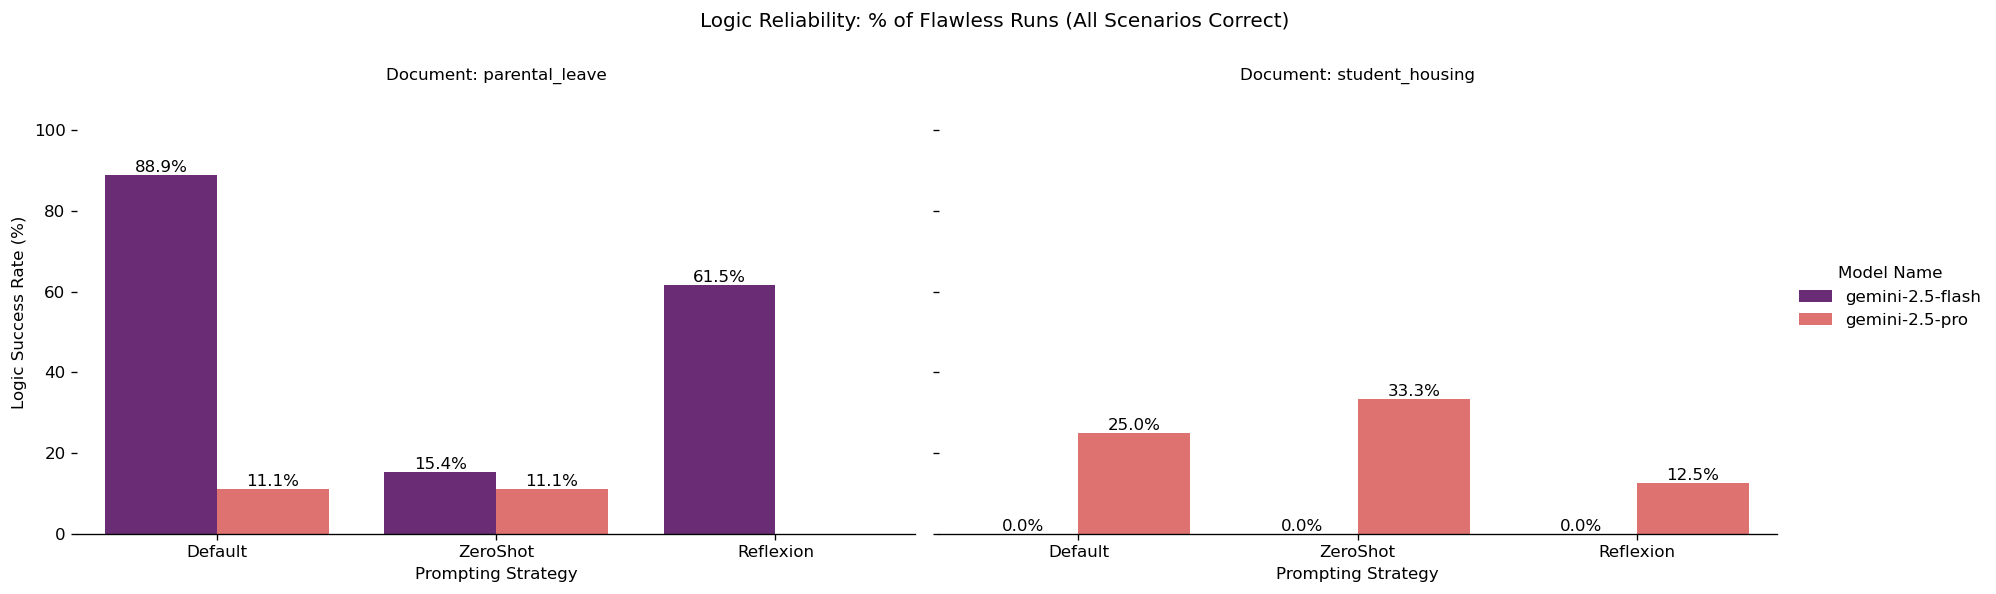

In [12]:
# Filter: Keep only runs where the pipeline succesfully executed
valid_syntax_df = df[df["Successfully Executed"] == 'True'].copy()

# Row-Level Check: Did this specific scenario match perfectly?
valid_syntax_df['Strict_Scenario_Match'] = (
    valid_syntax_df['Actual Violation Count'] == valid_syntax_df['Expected Violation Count']
)

# Group by Run ID and config tuple
run_logic_df = valid_syntax_df.groupby(['Run ID', 'Document Name', 'Model Name', 'Prompts']).agg({
    'Strict_Scenario_Match': 'all' # Logic: AND(Scenario1, Scenario2, ...)
}).reset_index()

# Rename for clarity
run_logic_df.rename(columns={'Strict_Scenario_Match': 'Perfect_Logic'}, inplace=True)

# Group by Config to get % Success
logic_stats = run_logic_df.groupby(['Document Name', 'Model Name', 'Prompts'])['Perfect_Logic'].mean().reset_index()
logic_stats['Logic Success Rate (%)'] = logic_stats['Perfect_Logic'] * 100

# Draw Chart
g = sns.catplot(
    data=logic_stats,
    kind="bar",
    x="Prompts",
    y='Logic Success Rate (%)',
    hue="Model Name",
    col="Document Name",
    palette="magma",
    height=5, 
    aspect=1.5,
    order=[p for p in ["Default", "ZeroShot", "Reflexion"]] # Define Order for X-Axis
)

# Polish
g.despine(left=True)
g.set_axis_labels("Prompting Strategy", "Logic Success Rate (%)")
g.set_titles("Document: {col_name}")
plt.ylim(0, 110)

# Add Labels
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')

plt.subplots_adjust(top=0.85)
g.figure.suptitle("Logic Reliability: % of Flawless Runs (All Scenarios Correct)")
plt.savefig(f"{IMAGE_DIR}/Logic Reliability.png", dpi=300, bbox_inches='tight')
plt.show()


## Overall Performance Indicators

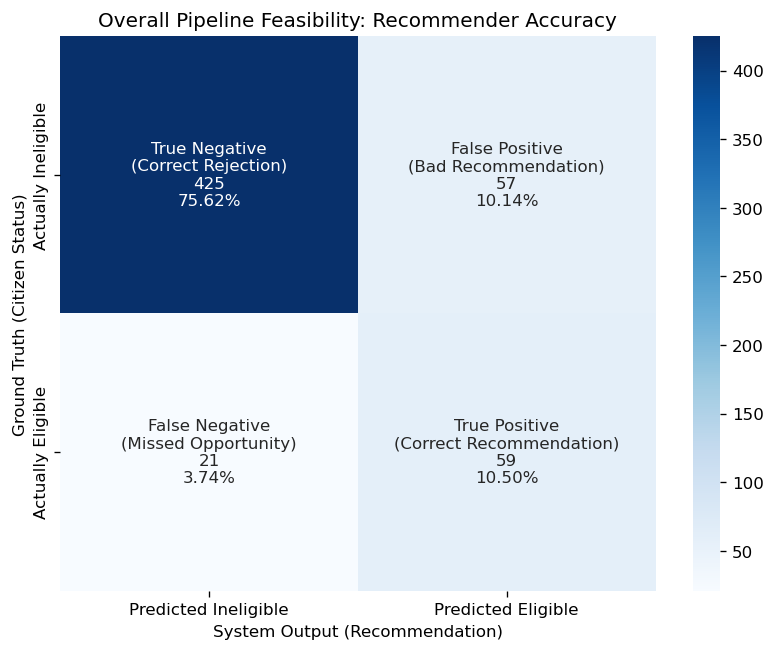

In [13]:
# Filter Valid Runs only
valid_df = df[df["Successfully Executed"] == 'True'].copy()

# Define Definitions (aligned with Recommender View)
y_true = valid_df['Expected Violation Count'] == 0 # Ground Truth: Is the citizen actually eligible? (Expected Violations == 0)
y_pred = valid_df['Actual Violation Count'] == 0 # System Prediction: Did the system recommend it? (Actual Violations == 0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[False, True]) # Labels: [False (Ineligible), True (Eligible)]

# Plot
plt.figure(figsize=(8, 6))

# Custom Labels for clarity
group_names = ['True Negative\n(Correct Rejection)', 'False Positive\n(Bad Recommendation)', 
               'False Negative\n(Missed Opportunity)', 'True Positive\n(Correct Recommendation)']

# Flatten the matrix to match names
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(
    cm, 
    annot=labels, 
    fmt='', 
    cmap='Blues',
    xticklabels=['Predicted Ineligible', 'Predicted Eligible'],
    yticklabels=['Actually Ineligible', 'Actually Eligible']
)

plt.title("Overall Pipeline Feasibility: Recommender Accuracy")
plt.ylabel("Ground Truth (Citizen Status)")
plt.xlabel("System Output (Recommendation)")
plt.savefig(f"{IMAGE_DIR}/Recommender Confusion Matrix.png", dpi=300, bbox_inches='tight')
plt.show()

Overall reliability

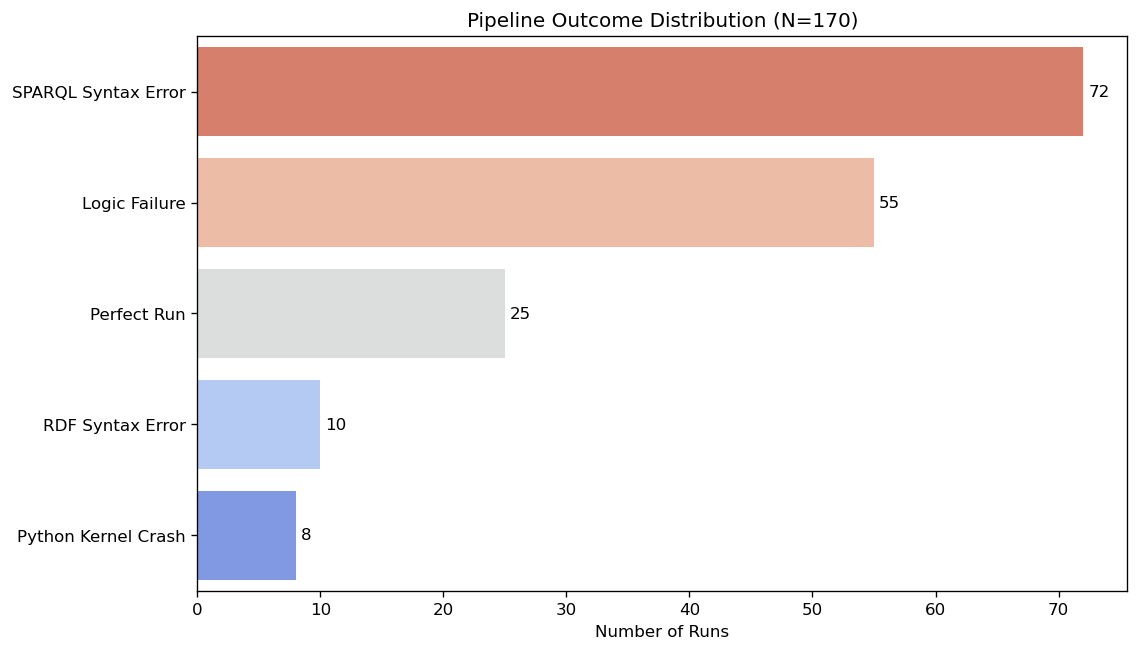

In [42]:
# Define a categorization Function
def categorize_run_outcome(group):
    # 'group' is a DataFrame representing ONE Run ID (all scenarios)
        
    # Did the pipeline crash?
    successfully_executed = str(group['Successfully Executed'].iloc[0])
    if successfully_executed not in ["True", "False"]:
        return "Python Kernel Crash"
    
    # Did the SHACL compile?
    syntax_error_type = group['SHACL Error Type'].iloc[0]
    if syntax_error_type != "VALID":        
        return f"{syntax_error_type.split('_')[0]} Syntax Error" # Return the specific syntax error type 
    
    # Did it pass ALL Logic tests? (scenarios)
    is_perfect = (group['Actual Violation Count'] == group['Expected Violation Count']).all()    
    if is_perfect:
        return "Perfect Run"
    else:
        return "Logic Failure"

# Apply to Data
run_outcomes = df.groupby("Run ID").apply(categorize_run_outcome, include_groups=False) # Group by Run ID and apply the function

# Aggregate Counts
outcome_counts = run_outcomes.value_counts().reset_index()
outcome_counts.columns = ['Outcome', 'Count']

# Visualization
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=outcome_counts,
    y="Outcome",
    x="Count",
    hue="Outcome", 
    palette="coolwarm_r" # Red (Crash) -> Blue (Perfect)
)

# Polish
plt.title(f"Pipeline Outcome Distribution (N={total_n_runs})")
plt.xlabel(f"Number of Runs")
plt.ylabel("")

# Add Labels
for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.savefig(f"{IMAGE_DIR}/Outcome Distribution.png", dpi=300, bbox_inches='tight')
plt.show()